In [152]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
import dill as pickle
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import label_binarize

%matplotlib inline

plt.style.use('ggplot')

In [2]:
nm = pd.read_pickle("data/rev_df_before_dummies.pkl")

In [3]:
col_lst = list(nm.columns)

In [4]:
nm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2047618 entries, 0 to 3986667
Data columns (total 13 columns):
CAD_Event_Number     int64
Force_Level          object
Precinct             object
Sector               object
Beat                 object
Subject_Race         object
Subject_Gender       object
Call_Type            object
Initial_Call_Type    object
month                int64
day                  int64
day_of_week          int64
hour                 int64
dtypes: int64(5), object(8)
memory usage: 218.7+ MB


In [5]:
forces = nm.groupby("Force_Level")

In [6]:
forces.count().iloc[:,1].values

array([2035580,    8953,    2852,      90,     143])

In [7]:
forces.count().index

Index([                       0, 'Level 1 - Use of Force',
       'Level 2 - Use of Force',          'Level 3 - OIS',
       'Level 3 - Use of Force'],
      dtype='object', name='Force_Level')

''

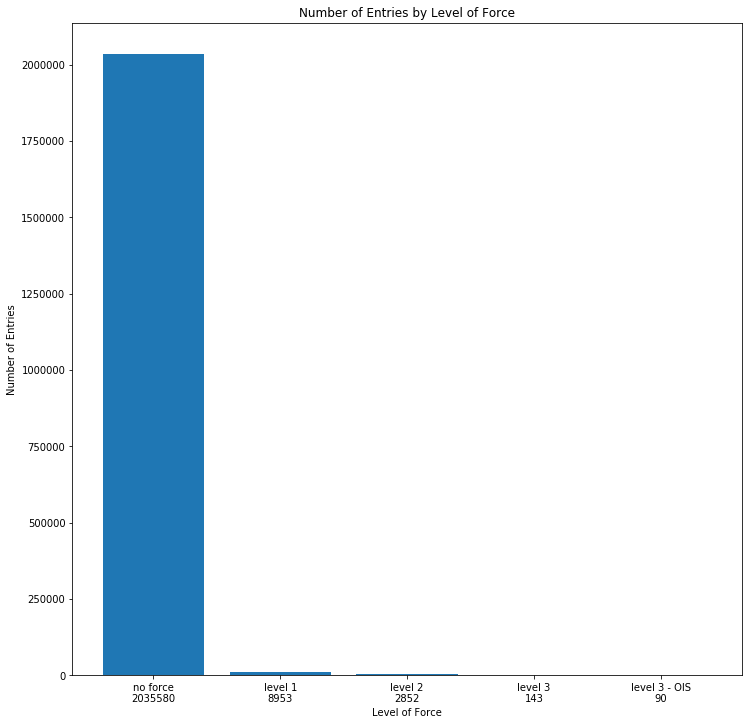

In [8]:
plt.figure(figsize=(12,12))
plt.bar(["no force\n2035580", "level 1\n8953", "level 2\n2852", "level 3\n143", "level 3 - OIS\n90"], forces.count().iloc[:,1].values)
plt.xlabel("Level of Force")
plt.ylabel("Number of Entries")
plt.title("Number of Entries by Level of Force")
;

#plt.savefig("imbalanced classes.jpg")


In [9]:
# categories would be good

In [10]:
# level of force by gender
sr = nm.groupby(["Force_Level", "Subject_Gender"]).Subject_Race.value_counts()
sr.index
sr.loc["Level 3 - OIS"]["Female"]

Subject_Race
Black or African American    14
White                         2
Name: Subject_Race, dtype: int64

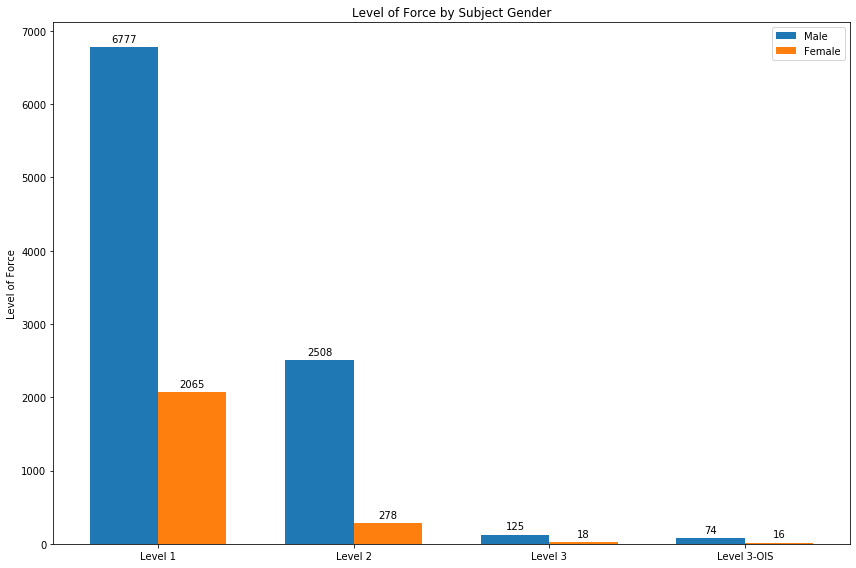

In [11]:
labels = ['Level 1', 'Level 2', 'Level 3', 'Level 3-OIS']
male = [6777, 2508, 125, 74]
female = [2065, 278, 18, 16]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Level of Force')
ax.set_title('Level of Force by Subject Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("force_bar_SG")

In [12]:
values = list(forces.Subject_Race.value_counts().values)
level1 = values[1:8]
level2 = values[9:16]
level3 = values[17:21]
level4 = values[21:28]
forces.Subject_Race.value_counts().loc["Level 1 - Use of Force"]
forces.count()

,CAD_Event_Number,Precinct,Sector,Beat,Subject_Race,Subject_Gender,Call_Type,Initial_Call_Type,month,day,day_of_week,hour
Force_Level,,,,,,,,,,,,
0,2035580,2035580,2023050,2035580,2035580,2035580,2035580,2035580,2035580,2035580,2035580,2035580
Level 1 - Use of Force,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953,8953
Level 2 - Use of Force,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852,2852
Level 3 - OIS,90,90,90,90,90,90,90,90,90,90,90,90
Level 3 - Use of Force,143,143,143,143,143,143,143,143,143,143,143,143


In [13]:
races = nm.groupby("Subject_Race")

In [14]:
races.Force_Level.value_counts().loc["Black or African American"]

Force_Level
Level 1 - Use of Force    3086
Level 2 - Use of Force     996
Level 3 - OIS               37
Level 3 - Use of Force      32
Name: Force_Level, dtype: int64

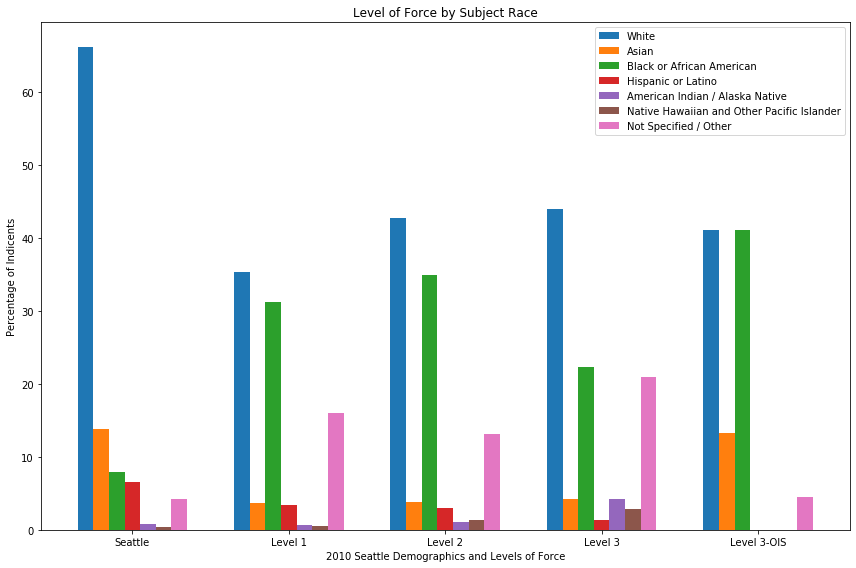

In [15]:
labels = ['Seattle','Level 1', 'Level 2', 'Level 3', 'Level 3-OIS']
White = [66.3, ((3483/9853)*100),((1222/2852)*100), ((63/143)*100),((37/90)*100)]
Asian = [13.8, ((360/9853)*100),((108/2852)*100), ((6/143)*100),((12/90)*100)]
Black = [7.9, ((3086/9853)*100),((996/2852)*100), ((32/143)*100),((37/90)*100)]
Hispanic = [6.6, ((338/9853)*100), ((86/2852)*100), ((2/143)*100), 0]
American_Indian = [0.8, ((66/9853)*100),((29/2852)*100), ((6/143)*100),0]
Hawaiian = [0.4, ((46/9853)*100),((38/2852)*100), ((4/143)*100),0]
Other = [4.2, ((1574/9853)*100),((373/2852)*100), ((30/143)*100),((4/90)*100)]



x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width*3, White, width, label='White')
rects2 = ax.bar(x - width*2, Asian, width, label='Asian')
rects3 = ax.bar(x - width, Black, width, label='Black or African American')
rects4 = ax.bar(x ,  Hispanic, width, label='Hispanic or Latino')
rects5 = ax.bar(x + width, American_Indian, width, label='American Indian / Alaska Native')
rects6 = ax.bar(x + width*2, Hawaiian, width, label='Native Hawaiian and Other Pacific Islander')
rects7 = ax.bar(x + width*3, Other, width, label='Not Specified / Other')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of Indicents')
ax.set_xlabel("2010 Seattle Demographics and Levels of Force")
ax.set_title('Level of Force by Subject Race')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

'''
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')'''
'''autolabel(rects1)
autolabel(rects2)'''

fig.tight_layout()


plt.savefig("force_percentage_SR.jpg")

In [16]:
'''# heatmap

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data)

# change color lims of map
ax = sns.heatmap(uniform_data, vmin=0, vmax=1)

# centered on zero with diverging color map
>>> normal_data = np.random.randn(10, 12)
>>> ax = sns.heatmap(normal_data, center=0)

# meaningful labels
>>> flights = sns.load_dataset("flights")
>>> flights = flights.pivot("month", "year", "passengers")
>>> ax = sns.heatmap(flights)

# with integers
>>> ax = sns.heatmap(flights, annot=True, fmt="d")

# different colormap
>>> ax = sns.heatmap(flights, cmap="YlGnBu")

# center colormap at a specific spot
>>> ax = sns.heatmap(flights, center=flights.loc["January", 1955])

# plot everyother column name and don't plot row labels
>>> data = np.random.randn(50, 20)
>>> ax = sns.heatmap(data, xticklabels=2, yticklabels=False)

'''

'# heatmap\n\nuniform_data = np.random.rand(10, 12)\nax = sns.heatmap(uniform_data)\n\n# change color lims of map\nax = sns.heatmap(uniform_data, vmin=0, vmax=1)\n\n# centered on zero with diverging color map\n>>> normal_data = np.random.randn(10, 12)\n>>> ax = sns.heatmap(normal_data, center=0)\n\n# meaningful labels\n>>> flights = sns.load_dataset("flights")\n>>> flights = flights.pivot("month", "year", "passengers")\n>>> ax = sns.heatmap(flights)\n\n# with integers\n>>> ax = sns.heatmap(flights, annot=True, fmt="d")\n\n# different colormap\n>>> ax = sns.heatmap(flights, cmap="YlGnBu")\n\n# center colormap at a specific spot\n>>> ax = sns.heatmap(flights, center=flights.loc["January", 1955])\n\n# plot everyother column name and don\'t plot row labels\n>>> data = np.random.randn(50, 20)\n>>> ax = sns.heatmap(data, xticklabels=2, yticklabels=False)\n\n'

In [80]:
# heatmap of categories and levels of force

df = pd.read_pickle("nm_cat_nodumdum")

# df = pd.DataFrame(index=pd.MultiIndex.from_product([df2["cat_ICT"],df2["Force_Level"]]))

In [81]:
indexNames = df[df['Force_Level'] == 0 ].index

In [86]:
sa = df.loc[indexNames]

In [130]:
len(sa), len(df), len(indexNames), len(df2), len(heat_col_lst)

(2035580, 2047618, 2035580, 12038, 11)

In [72]:
df2.columns, len(df2)

indexNames = df2[df2['Force_Level'] == 0 ].index
 
# Delete these row indexes from dataFrame
df2 = df2.drop(indexNames )



In [73]:
'''var = df2.groupby(["Force_Level", "Beat"]).count()
var.index
cats = []
beats = []
vals = var.values
for i in range(len(var.index)):
    cats.append(var.index[i][0])
    beats.append(var.index[i][1])
'''

In [119]:
col_lst = list(df2.columns)

heat_col_lst = col_lst.copy()

In [265]:
df.columns

Index(['Force_Level', 'Precinct', 'Sector', 'Beat', 'Subject_Race',
       'Subject_Gender', 'Call_Type', 'month', 'day_of_week', 'sin_hour2',
       'cos_hour2', 'cat_ICT'],
      dtype='object')

In [258]:
# make df for each Force level for plotting purposes
four = df[df["Force_Level"] == "Level 3 - OIS"]
three = df[df["Force_Level"] == "Level 3 - Use of Force"]
two = df[df["Force_Level"] == "Level 2 - Use of Force"]
one = df[df["Force_Level"] == "Level 1 - Use of Force"]
zero = df[df["Force_Level"] == 0]

In [ ]:
dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow4 = ["Monday", "Tuesday", "Wednesday", "Friday", "Saturday", "Sunday"]

In [285]:
def heatmaps(df, col_1, col_2, ax, **kwargs):
    # optional arguments - xticklabels, yticklabels
    
    var2 = df.groupby([col_1, col_2]).count()
    counts = var2[["Call_Type"]]
    table = counts.reset_index()
    heat = table.pivot(index=col_1, columns=col_2, values="Call_Type")
    #fig, ax = plt.subplots(1,1, figsize=(12,8))
   
   
        
    ax.tick_params(axis='y', rotation=0)
    sns.heatmap(heat, ax=ax)
    
    

In [332]:
four.cat_ICT.value_counts()

Shots heard                             17
Suicidal person or attempts             15
Robbery                                 14
Suspicious person, vehicle, incident    10
Motor Vehicle Collision                  8
Threats                                  4
Disturbance                              4
Deadly Weapon - No Assault               4
Follow up                                3
Police Initiated - Off Duty              2
Domestic Violence                        2
Assault                                  2
Parking Violation                        2
-                                        1
Assisting other agencies                 1
Police Initiated - On Duty               1
Name: cat_ICT, dtype: int64

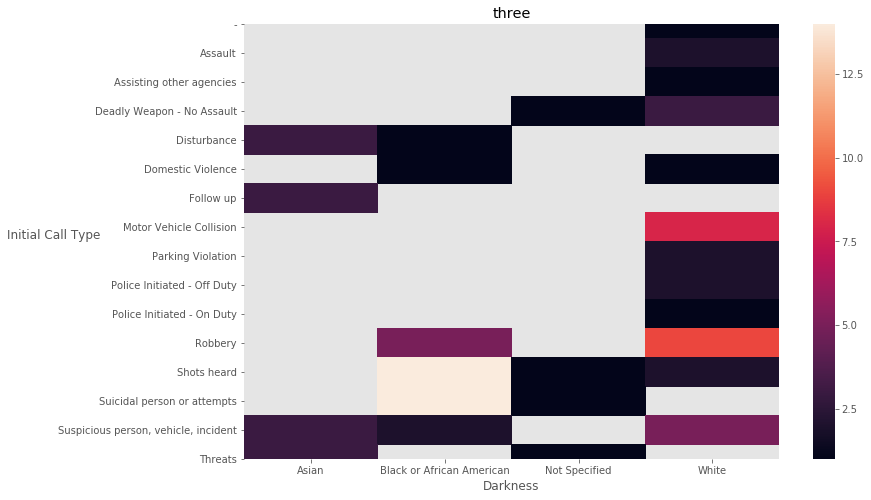

In [333]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title("three")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

    
#ax.set_yticklabels( fontdict={'verticalalignment': 'center','horizontalalignment': 'right'})
heatmaps(four, "cat_ICT", 'Subject_Race', ax)
ax.set_xlabel("Darkness")
ax.set_ylabel("Initial Call Type", rotation=0);
#ax.ticklabel_format(useOffset=False)
#ax.set_xticklabels(np.linspace(-1,1, num=20));

#fig.savefig('heat_zero_SR_ICT.png')


## cosine 1 = midnight, -1 = noon, zeros and 6 and 18
## sine 1= 0600, -1 = 1800, zeros at midnight and noon

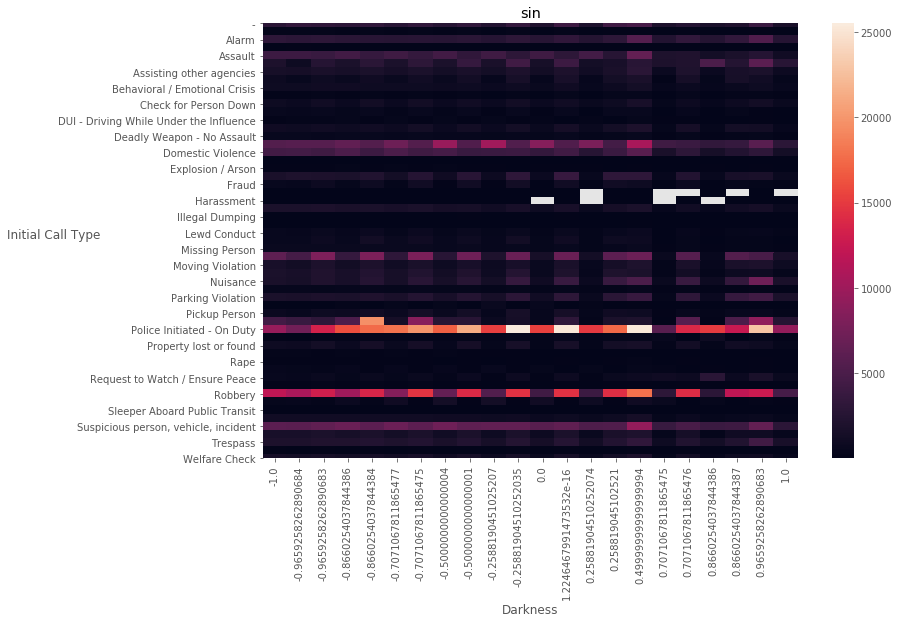

In [326]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.set_title("sin")

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

    
#ax.set_yticklabels( fontdict={'verticalalignment': 'center','horizontalalignment': 'right'})
heatmaps(zero, "cat_ICT", 'sin_hour2', ax)
ax.set_xlabel("Darkness")
ax.set_ylabel("Initial Call Type", rotation=0);

In [ ]:
# This was a matplotlib regression introduced in 3.1.1 which has been fixed in 3.1.2 (still forthcoming). 
# For now the fix is to downgrade matplotlib to a prior version.





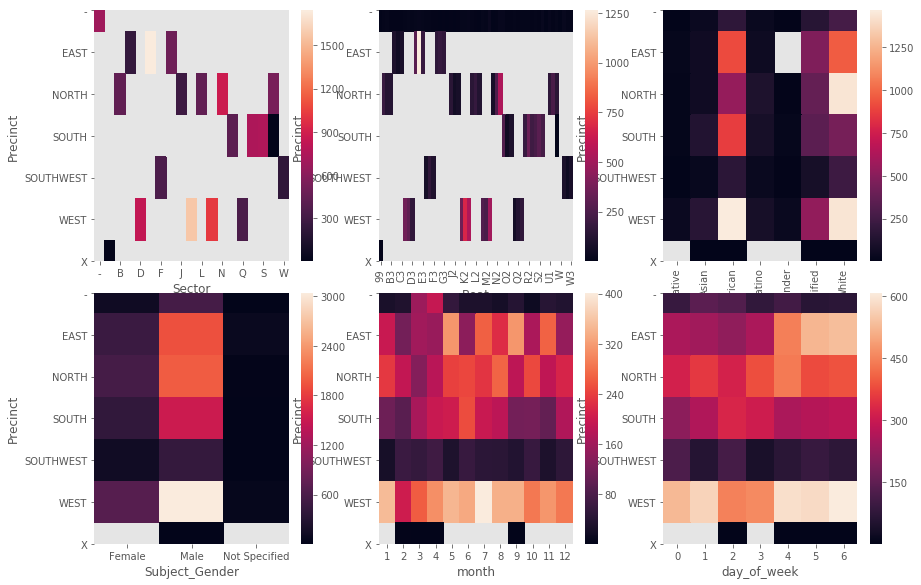

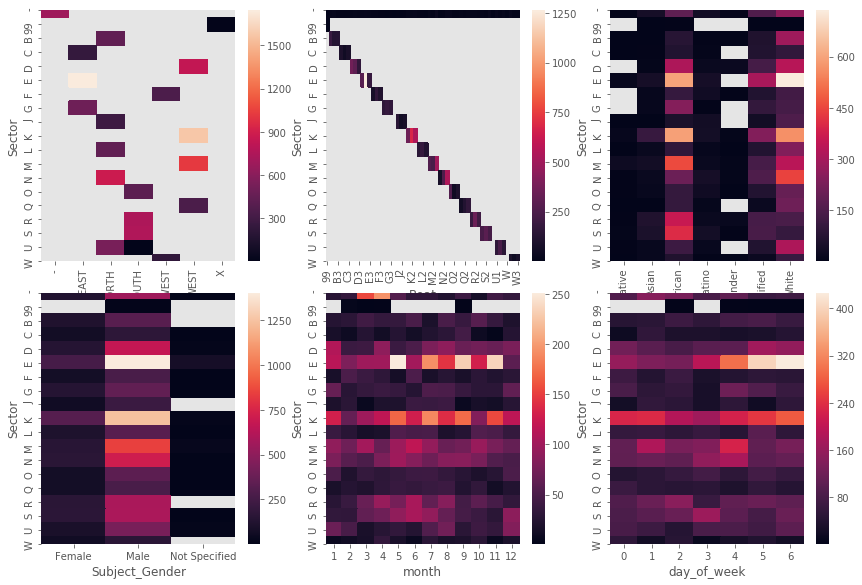

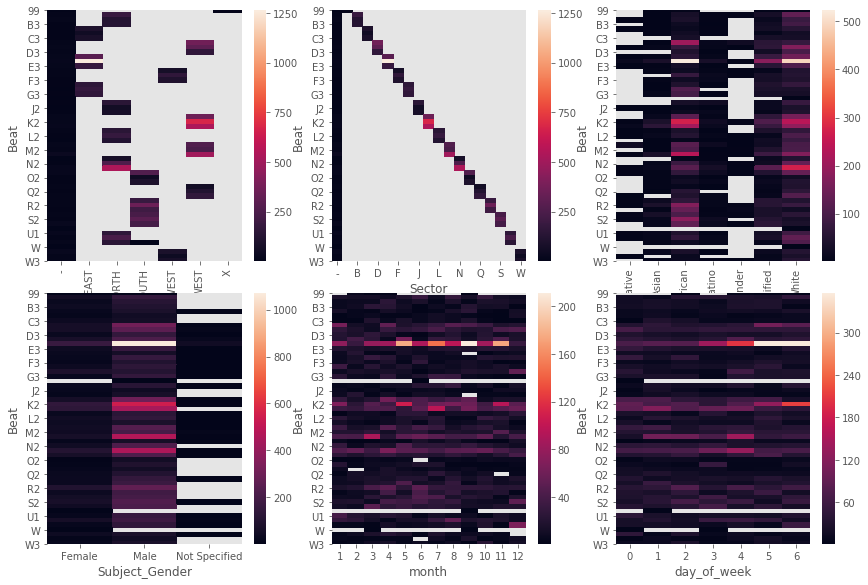

In [206]:

#fig.subplots_adjust(left=.5, bottom=.3, top=.9, wspace=.5, hspace=.9)

for i in heat_col_lst[:3]:
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    fig.tight_layout()
    new_lst = heat_col_lst.copy()
    new_lst.remove(i)
    for j,ax in  zip(new_lst[:6], axs.flatten()):
        if i != j:
          
            heatmaps(df2, i, j,ax)
        else:
            pass
            #sl.append((heat_col_lst[i], heat_col_lst[j]))

In [197]:
maps

[None, None]

In [ ]:
'''cat_vc = df.groupby("cat_ICT")["Force_Level"].value_counts()

years = range(2016,2019)
months = range(1,6)

df = pd.DataFrame(index=pd.MultiIndex.from_product([years,months]))
df['vals'] = df2.groupby("cat_ICT")["Force_Level"].value_counts().values

df3 = df.reset_index().pivot(columns='level_0',index='level_1',values='vals')

sns.heatmap(df2)'''

In [ ]:
# heatmap of force against all others

sns.heatmap()

In [ ]:
# distributions
sns.distplot(titanic.age.dropna())
sns.plt.show()

# multi-level pivot tables
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

In [290]:
def greet(name, msg = "Good morning!", msg2="Come on in"):
   """
   This function greets the person with given message.
   If message is not given, it defaults to "Good
   morning!"
   """
   print("Hello",name + ', ' + msg + ' '+ msg2)

In [335]:
calls = pd.read_pickle("data/calls17_cleaned_not_in_rev_df.pkl")

In [337]:
calls.drop(["CAD Event Number", "year"], axis=1, inplace=True)
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072055 entries, 1672126 to 3986667
Data columns (total 15 columns):
Event Clearance Description    object
Call Type                      object
Priority                       int64
Initial Call Type              object
Final Call Type                object
Arrived Time                   object
Precinct                       object
Sector                         object
Beat                           object
day                            object
month                          int64
time                           object
Original_Time_Queued           datetime64[ns]
day_of_week                    int64
hour                           int64
dtypes: datetime64[ns](1), int64(4), object(10)
memory usage: 252.9+ MB


In [338]:
calls.head()

,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Arrived Time,Precinct,Sector,Beat,day,month,time,Original_Time_Queued,day_of_week,hour
1672126,DUPLICATED OR CANCELLED BY RADIO,911,2,ASLT - DV,ASLT - DV,Jan 1 2014 04:05:07:000AM,NORTH,BOY,B1,1,1,04:05:07:000AM,2014-01-01 01:35:47,2,1
1673123,OTHER REPORT MADE,ONVIEW,3,FOLLOW UP,--WARRANT SERVICES - FELONY,Jan 1 2014 04:37:55:000AM,WEST,DAVID,D2,1,1,04:37:55:000AM,2014-01-01 04:37:55,2,4
1673296,ASSISTANCE RENDERED,911,2,SHOPLIFT - THEFT,--THEFT - SHOPLIFT,Jan 1 2014 08:24:49:000PM,SOUTH,SAM,S2,1,1,08:24:49:000PM,2014-01-01 20:18:44,2,20
1673471,ASSISTANCE RENDERED,911,2,SHOPLIFT - THEFT,--PROWLER - TRESPASS,Jan 5 2014 05:52:07:000PM,NORTH,NORA,N2,5,1,05:52:07:000PM,2014-01-05 17:48:08,6,17
1674098,REPORT WRITTEN (NO ARREST),911,5,TRU - THEFT,--THEFT - CAR PROWL,Jan 7 2014 09:41:30:000PM,NORTH,BOY,B3,7,1,09:41:30:000PM,2014-01-07 21:39:40,1,21


In [341]:
calls[["Event Clearance Description", "Initial Call Type","Final Call Type"]]

,Event Clearance Description,Initial Call Type,Final Call Type
1672126,DUPLICATED OR CANCELLED BY RADIO,ASLT - DV,ASLT - DV
1673123,OTHER REPORT MADE,FOLLOW UP,--WARRANT SERVICES - FELONY
1673296,ASSISTANCE RENDERED,SHOPLIFT - THEFT,--THEFT - SHOPLIFT
1673471,ASSISTANCE RENDERED,SHOPLIFT - THEFT,--PROWLER - TRESPASS
1674098,REPORT WRITTEN (NO ARREST),TRU - THEFT,--THEFT - CAR PROWL
1674201,ASSISTANCE RENDERED,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT
1674409,ASSISTANCE RENDERED,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT
1674513,ASSISTANCE RENDERED,REQUEST TO WATCH,REQUEST TO WATCH
1674584,ASSISTANCE RENDERED,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT
1675205,ASSISTANCE RENDERED,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT


In [342]:
force = pd.read_csv("data/Use_Of_Force.csv")

In [343]:
force.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 11 columns):
ID                   9838 non-null object
Incident_Num         9838 non-null int64
Incident_Type        9838 non-null object
Occured_date_time    9838 non-null object
Precinct             9838 non-null object
Sector               9838 non-null object
Beat                 9838 non-null object
Officer_ID           9838 non-null int64
Subject_ID           9838 non-null int64
Subject_Race         9838 non-null object
Subject_Gender       9838 non-null object
dtypes: int64(3), object(8)
memory usage: 845.5+ KB
